## Challenge 2 (2 points)
Signal in colored, Gaussian noise.

- Use the data file challenge2.gwf, with channel name H1:CHALLENGE2.
- The data contain a BBH signal with m1 = m2 = 30 solar masses, spin = 0.
1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)
2. Generate a time-domain template waveform using approximate SEOBNRv4_opt. with the same parameters as above. Plot this waveform.
3. Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 Hz up to the Nyquist frequency.
4. Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.
5. What is the matched filter SNR of the signal?

Importing the necessary libraries

In [2]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform, fd_approximants

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


Loading the data

In [3]:
data = TimeSeries.read("challenge2.gwf", channel = "H1:CHALLENGE2")

Plotting a q-transform to approximate the merger time.

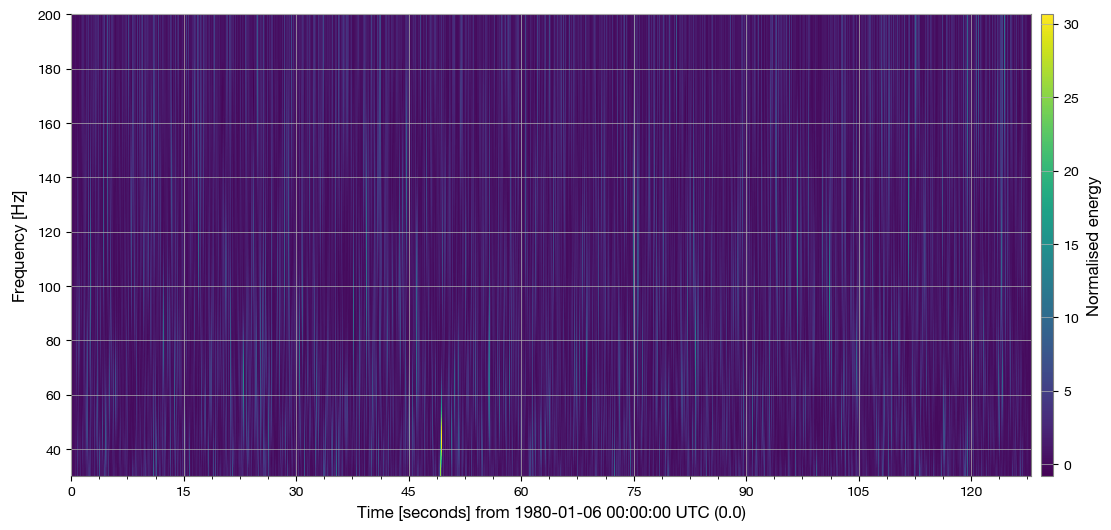

In [ ]:
hq = data.q_transform(frange=(30, 200))
plot = hq.plot()
plot.colorbar(label="Normalised energy")

We can see a peak around 49 seconds.

Next we plot the signal strain.

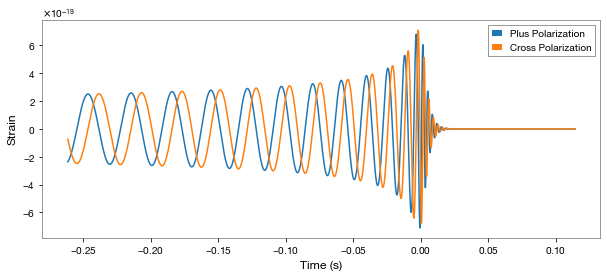

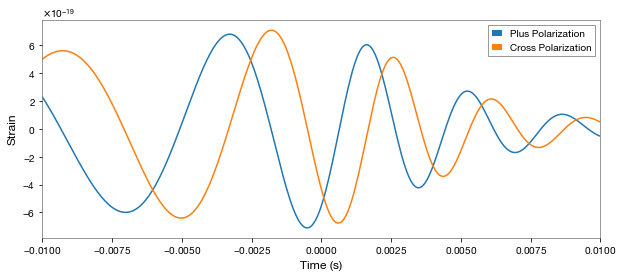

In [5]:
# The outputs of this function are the "plus" and "cross" polarizations 
# of the gravitational-wave signal as viewed from the line of sight at 
# a given source inclination (assumed face-on, i.e. zero inclination
# if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/16384,
                         f_lower=30)

plt.figure(figsize=plt.figaspect(0.4))
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid()
plt.show()

# Zoom in near the merger time
plt.figure(figsize=plt.figaspect(0.4))
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.xlim(-.01, .01)
plt.legend()
plt.grid()
plt.show()

The PSD of the data in the log-log scale is plotted next.

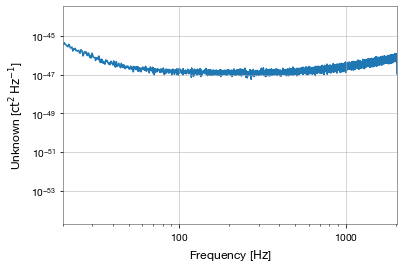

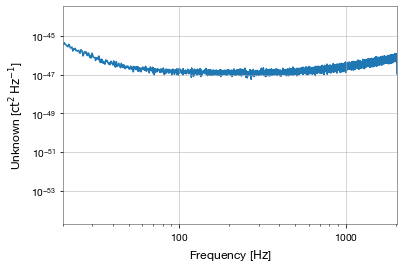

In [6]:
psd = data.psd(fftlength=4, overlap=2)
nyquist_freq = data.sample_rate.value / 2

# Plot from 20 Hz up to Nyquist
psd.plot(xscale='log', yscale='log', xlim=(20, nyquist_freq))

In [32]:
from pycbc.types import TimeSeries as pycbc_TimeSeries
conditioned=pycbc_TimeSeries(data.value,delta_t=data.dt.value)
dt = conditioned.delta_t
duration = conditioned.duration

In [ ]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [33]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=dt,
                         f_lower=30)

In [34]:
hp.resize(len(conditioned))

In [35]:
template = hp.cyclic_time_shift(hp.start_time)

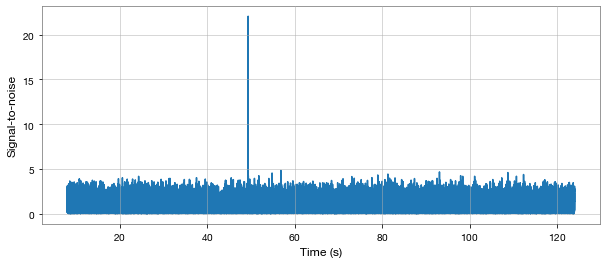

We found a signal at 49.3671875s with SNR 22.035851536924838


In [36]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

Hence we found that the SNR of the signal is 22.03 with the merger at 49.36s matching our initial guess from the q-transform.